In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('data.csv', encoding='ISO-8859-1')  # encoding fixes common character issues

In [4]:
#1 Data understanding
# first few rows
print(df.head())

# Overview
print(df.info())

# Missing values
print(df.isnull().sum())

# Unique values
print(df.nunique())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [5]:
# 2. Clean the dataset

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Drop rows with missing CustomerID or Description
df = df.dropna(subset=['CustomerID', 'Description'])

# Remove cancelled orders — InvoiceNo starting with 'C'
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove rows with Quantity <= 0 or UnitPrice <= 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Add TotalPrice = Quantity * UnitPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert CustomerID to integer (optional for consistency)
df['CustomerID'] = df['CustomerID'].astype(int)

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

# Final check
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 27.3+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 

In [6]:
# Check for negative values
print(df[df['Quantity'] < 0])  # Should return empty

# Check for cancelled invoices
print(df[df['InvoiceNo'].astype(str).str.startswith('C')])  # Should return empty

# Missing values
print(df.isnull().sum())  # Should return all zeros


Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalPrice]
Index: []
Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalPrice]
Index: []
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [7]:
# 3 Exploratory Data Analysis

print(f"💰 Total Revenue: £{df['TotalPrice'].sum():,.2f}")


💰 Total Revenue: £8,911,407.90


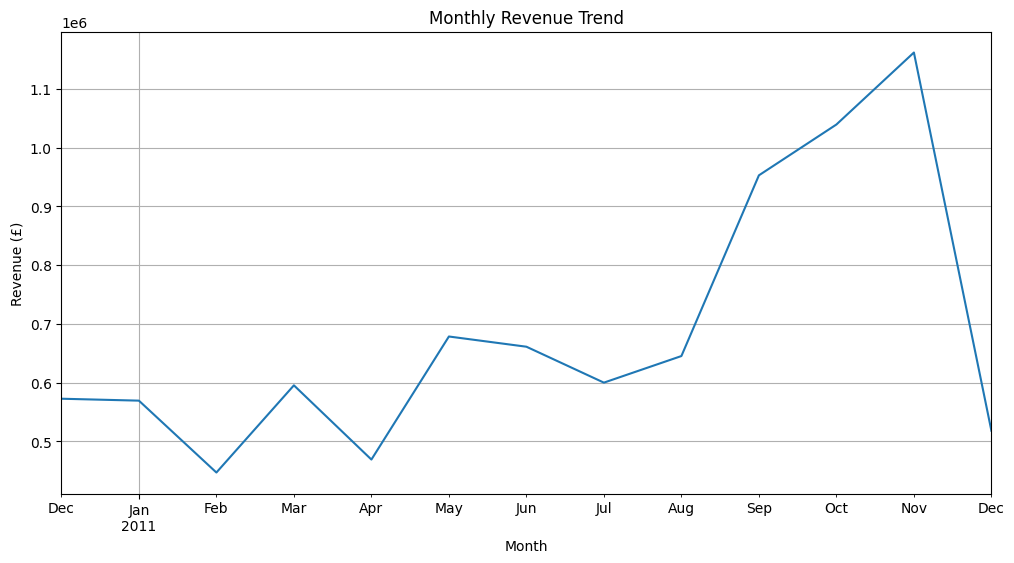

In [9]:
import matplotlib.pyplot as plt  # 👈 Required for plotting

# Add 'Month' column
df['Month'] = df['InvoiceDate'].dt.to_period('M')

# Group by month and sum revenue
monthly_revenue = df.groupby('Month')['TotalPrice'].sum()

# Plot monthly revenue trend
monthly_revenue.plot(kind='line', figsize=(12,6), title='Monthly Revenue Trend')
plt.ylabel('Revenue (£)')
plt.xlabel('Month')
plt.grid(True)
plt.show()


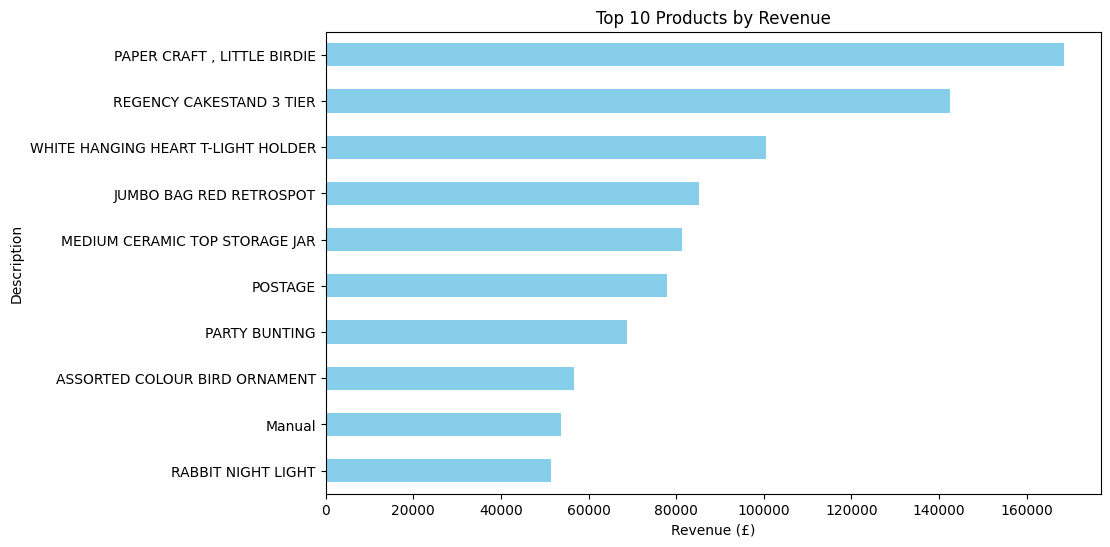

In [10]:
#top 10 product by revenue
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind='barh', figsize=(10,6), title='Top 10 Products by Revenue', color='skyblue')
plt.xlabel('Revenue (£)')
plt.gca().invert_yaxis()
plt.show()


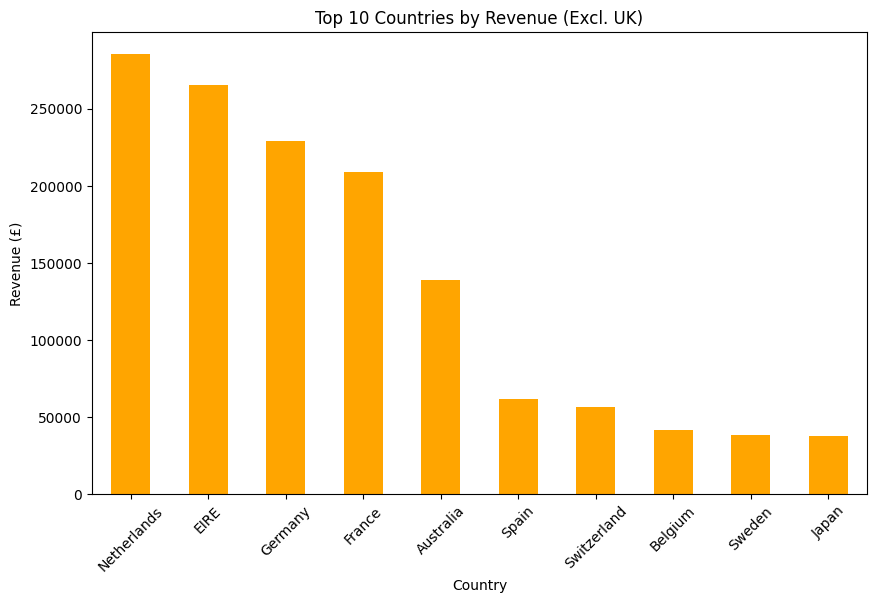

In [11]:
# Revenue by Country (excluding UK)
country_revenue = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

country_revenue.plot(kind='bar', figsize=(10,6), title='Top 10 Countries by Revenue (Excl. UK)', color='orange')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
plt.show()

Average Order Value: £480.87


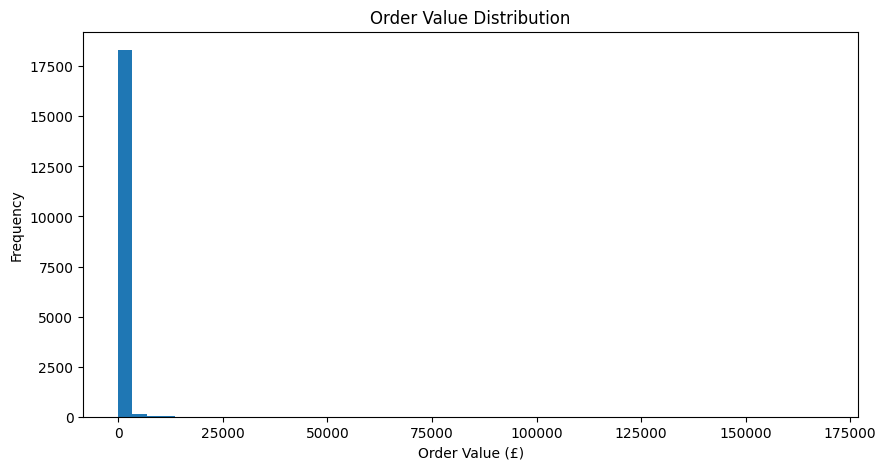

In [13]:
# Average Order Value
order_value = df.groupby('InvoiceNo')['TotalPrice'].sum()

print(f"Average Order Value: £{order_value.mean():.2f}")

order_value.plot(kind='hist', bins=50, title='Order Value Distribution', figsize=(10,5))
plt.xlabel('Order Value (£)')
plt.show()


In [14]:
# 4 Customer Segmentation (RFM)
import datetime as dt

#RFM Table
# Set snapshot date (1 day after last invoice)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# View RFM head
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40


In [15]:
# Assign RFM Scores
# Assign scores 1–4 (quartiles)
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine RFM scores
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,4,114
12347,2,7,4310.00,4,4,4,444
12348,75,4,1797.24,2,3,4,234
12349,19,1,1757.55,3,1,4,314
12350,310,1,334.40,1,1,2,112


In [16]:
# Segment Customers
# Define segment labels
def segment(rfm):
    if rfm['RFM_Score'] == '444':
        return 'Champions'
    elif int(rfm['R']) >= 3 and int(rfm['F']) >= 3:
        return 'Loyal Customers'
    elif int(rfm['R']) >= 3:
        return 'Recent Customers'
    elif int(rfm['F']) >= 3:
        return 'Frequent Buyers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment, axis=1)

# View segment counts
print(rfm['Segment'].value_counts())


Segment
Others              1504
Loyal Customers     1033
Recent Customers     665
Frequent Buyers      646
Champions            490
Name: count, dtype: int64


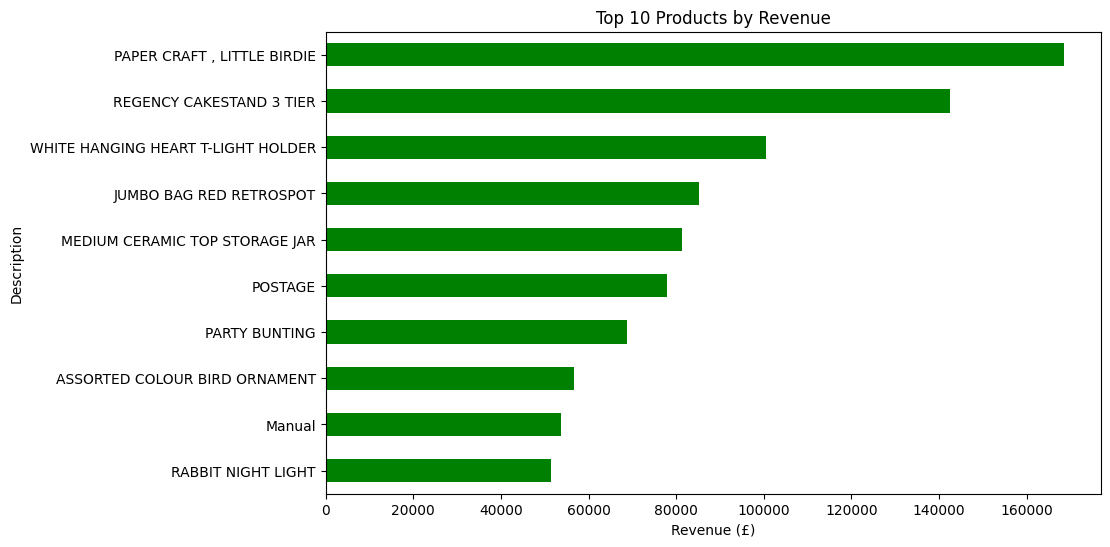

In [18]:
# Product Performance
##Top Products by Revenue
top_revenue_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

top_revenue_products.plot(kind='barh', figsize=(10,6), title='Top 10 Products by Revenue', color='green')
plt.xlabel('Revenue (£)')
plt.gca().invert_yaxis()
plt.show()

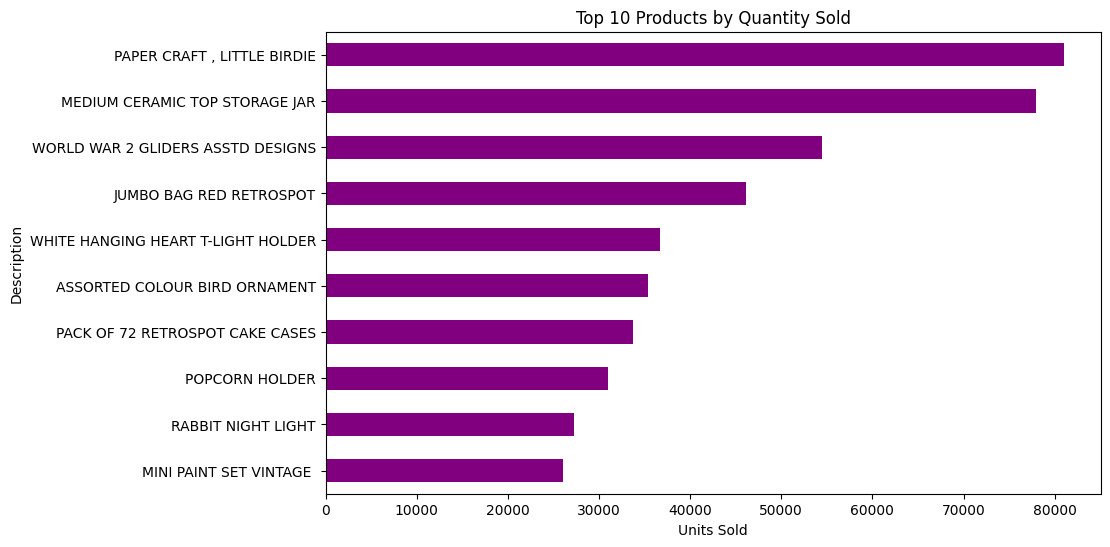

In [19]:
##Top Products by Quantity Sold
top_quantity_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

top_quantity_products.plot(kind='barh', figsize=(10,6), title='Top 10 Products by Quantity Sold', color='purple')
plt.xlabel('Units Sold')
plt.gca().invert_yaxis()
plt.show()

In [20]:
##High Revenue + Low Volume Products
product_perf = df.groupby('Description').agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})

premium = product_perf[(product_perf['Quantity'] < 100) & (product_perf['TotalPrice'] > 1000)].sort_values('TotalPrice', ascending=False)

print(premium.head(10))


                                    Quantity  TotalPrice
Description                                             
PICNIC BASKET WICKER 60 PIECES            61    39619.50
DOTCOM POSTAGE                            16    11906.36
VINTAGE RED KITCHEN CABINET               60     8125.00
LOVE SEAT ANTIQUE WHITE METAL             58     6210.00
RUSTIC  SEVENTEEN DRAWER SIDEBOARD        35     5415.00
VINTAGE BLUE KITCHEN CABINET              26     3685.00
CHEST NATURAL WOOD 20 DRAWERS             24     2745.00
HALL CABINET WITH 3 DRAWERS               75     2503.53
3 TIER SWEETHEART GARDEN SHELF            55     1938.25
IVORY EMBROIDERED QUILT                   46     1715.90


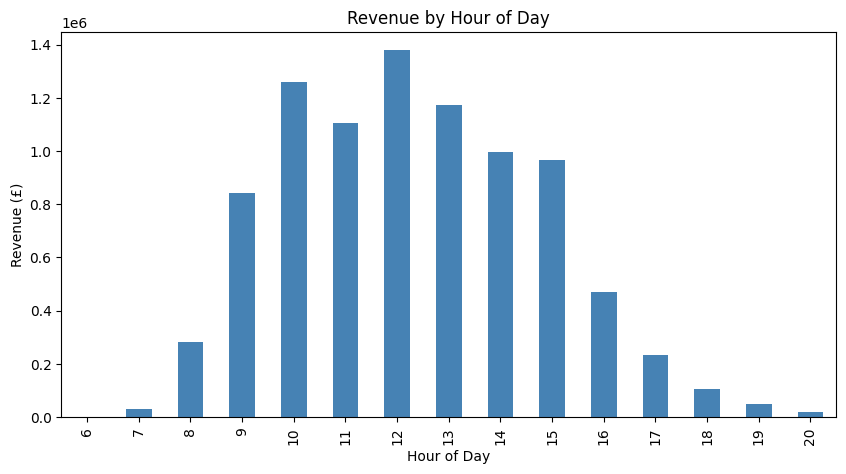

In [21]:
#Time-Based Sales Trends
##Revenue by Hour of Day
df['Hour'] = df['InvoiceDate'].dt.hour

df.groupby('Hour')['TotalPrice'].sum().plot(kind='bar', figsize=(10,5), title='Revenue by Hour of Day', color='steelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Revenue (£)')
plt.show()


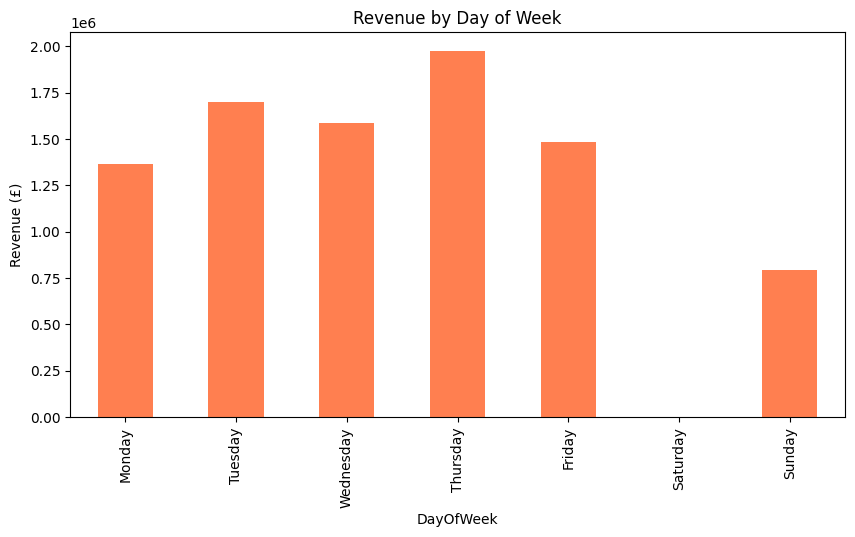

In [22]:
##Revenue by Day of Week
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

df.groupby('DayOfWeek')['TotalPrice'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', figsize=(10,5), title='Revenue by Day of Week', color='coral')
plt.ylabel('Revenue (£)')
plt.show()

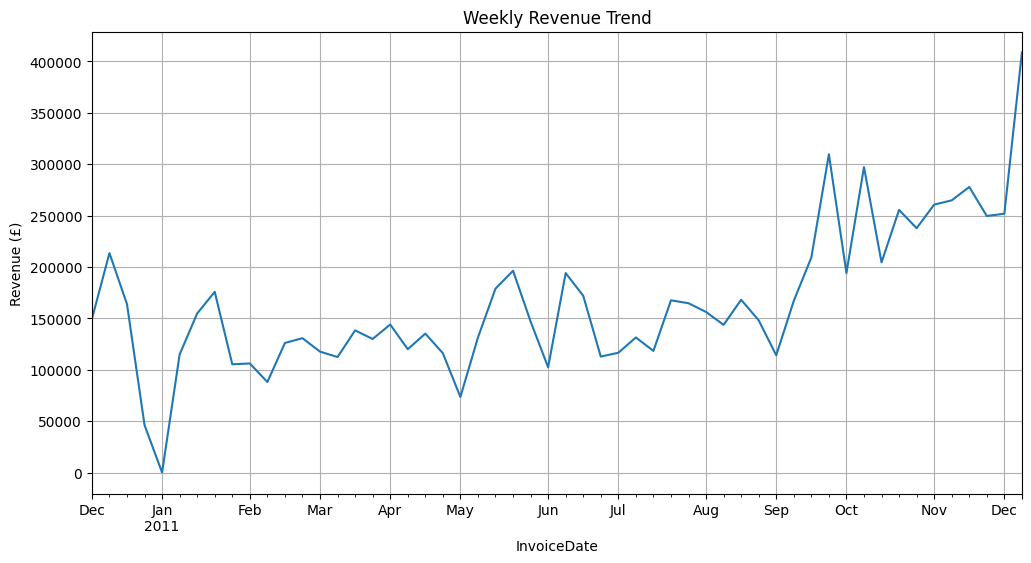

In [23]:
##Weekly Revenue
weekly_revenue = df.set_index('InvoiceDate').resample('W')['TotalPrice'].sum()

weekly_revenue.plot(kind='line', figsize=(12,6), title='Weekly Revenue Trend')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.show()


In [24]:
# Export full cleaned dataset
df.to_csv('cleaned_ecommerce_data.csv', index=False)

# Export RFM segments
rfm.to_csv('rfm_segments.csv')